In [1]:
import change_path

import pr_gain
import tf_memory_limit
import tf_memory_limit
from zinb import ZINB
import sequence

import pickle
import matplotlib.pyplot as plt
from keras.models import load_model
import datagen
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve

['', '/usr/lib/python35.zip', '/usr/lib/python3.5', '/usr/lib/python3.5/plat-x86_64-linux-gnu', '/usr/lib/python3.5/lib-dynload', '/home/kal/VENV/lib/python3.5/site-packages/', '/home/kal/VENV/lib64/python3.5/site-packages/', '/home/kal/VENV/lib/python3.5/site-packages/IPython/extensions/', '/home/kal/K27act_models/bin/', '/home/kal/TF_models/bin/', '/home/kal/.ipython']


Using TensorFlow backend.
/home/kal/TF_models/bin/sequence.py:275: RuntimeWarning: divide by zero encountered in log
  self.seq = helper.softmax(np.log(dist))


In [104]:
fbaseline_models = {'3f':pickle.load(open('/home/kal/K27act_models/cg_model/cg_cpg_atac_regression_fold_change.pk', 'rb'))} 
                   #'2f':pickle.load(open('/home/kal/K27act_models/cg_model/cg_cpg_regression_fold_change.pk', 'rb'))}
kbaseline_models = {'3k':pickle.load(open('/home/kal/K27act_models/cg_model/cg_cpg_atac_regression_k27act_norm.pk', 'rb'))}
                   #'2k':pickle.load(open('/home/kal/K27act_models/cg_model/cg_cpg_regression_k27act_norm.pk', 'rb'))}
fml_models = {} 
kml_models = {}
logkml_models = {'sum_pwm':load_model('/home/kal/K27act_models/convolution_model/20180730_150744_counts_pwm_sum/final_model.h5'), 
                'rec':load_model('/home/kal/K27act_models/convolution_model/20180730_151934_counts_recurrent/final_model.h5')}

In [86]:
#load in data
peaks_path = '/home/kal/K27act_models/GM_data/k27act_training_regions_cg.bed'
peaks = pd.read_table(peaks_path)
peaks['score'] = np.nan

# get test set
subpeaks = peaks[(peaks.chr == 'chr8') & (peaks.index%2 == 1)]
cutoff = len(subpeaks)//32
subpeaks=subpeaks[:cutoff*32]
print(len(subpeaks))
subpeaks.head()

3392


,chr,start,end,name,fold_change,atac,k27act,nucs,gc_frac,cpg_frac,score
149099,chr8,156467,157491,Peak_83609_ENCFF996CVE_dhs,-3.863588,13.556464,0.000000,ccgccgggcggggagcgcgggaatggcgaggtgcaggcgcagagac...,0.600586,0.044922,NaN
149101,chr8,181990,183014,Peak_28905_ENCFF411MHX_k27,0.030627,31.354554,32.048760,ACCCAGAGGCGGAGTGCGGGCTCGCGAGGGTCCCCACCCGACTCTC...,0.679688,0.100586,NaN
149103,chr8,221994,223018,Peak_53539_ENCFF411MHX_k27,0.094396,6.295875,6.789209,TCACACGACCTGCGGGGCGCCCCAGAGGCCAGGCGGCCGCTGGTTC...,0.534180,0.023438,NaN
149105,chr8,223740,224764,Peak_34885_ENCFF411MHX_k27,1.279614,3.187324,9.165738,ggggactgaggggtgggggaagggggtgtggggtggaaggtgtaga...,0.575195,0.016602,NaN
149107,chr8,354258,355282,Peak_38696_ENCFF411MHX_k27,0.569372,7.128076,11.061070,GTGTGGTGTGCATTGGAGAAGCGTGGGACCCCTGTGCTCACCACCA...,0.478516,0.006836,NaN


In [4]:
# predict baseline model
fbaseline_preds=dict()
for key in fbaseline_models:
    if '3' in key:
        fbaseline_preds[key] = fbaseline_models[key].predict(subpeaks[['gc_frac','cpg_frac', 'atac']])
    else:
        fbaseline_preds[key] = fbaseline_models[key].predict(subpeaks[['gc_frac','cpg_frac']])

kbaseline_preds=dict()
for key in kbaseline_models:
    if '3' in key:
        kbaseline_preds[key] = kbaseline_models[key].predict(subpeaks[['gc_frac','cpg_frac', 'atac']])
    else:
        kbaseline_preds[key] = kbaseline_models[key].predict(subpeaks[['gc_frac','cpg_frac']])
    
# extrapolate out the k27 act or the log fold
for key in fbaseline_models:
    kbaseline_preds[key] = (2**(fbaseline_preds[key]))*(subpeaks['atac']+1)-1

for key in kbaseline_models:
    fbaseline_preds[key] = np.log2((kbaseline_preds[key]+1)/(subpeaks['atac']+1))

In [105]:
# predict ml
batch_size=32 

def simple_gen():
    for index, row in subpeaks.iterrows():
        yield datagen.get_sample(row)
        
def simple_batch():
    d = simple_gen()
    while True:
        X = np.empty((batch_size, 1024, 5))
        y = np.empty((batch_size))
        for i in range(batch_size):
            inputs, score = next(d)
            X[i]=inputs
            y[i]=score
        yield X, y
        
#make dictionarys
ml_k27act_preds=dict()
ml_logk27act_preds = dict()
ml_fold_preds=dict()

# predict fold models and extrapolate out the k27 act or the log fold
for key in fml_models:
    ml_fold_preds[key] = fml_models[key].predict_generator(simple_batch(), 
                                                           steps=len(subpeaks)//batch_size).flatten()
    ml_k27act_preds[key] = (2**(ml_fold_preds[key]))*(subpeaks['atac']+1)-1
    
# predict acetylation models and extrapolate out the k27 act or the log fold
for key in kml_models:
    ml_k27act_preds[key] = kml_models[key].predict_generator(simple_batch(), 
                                                             steps=len(subpeaks)//batch_size).flatten()
    ml_fold_preds[key] = np.log2((ml_k27act_preds[key]+1)/(subpeaks['atac']+1))
for key in logkml_models:
    ml_logk27act_preds[key] = logkml_models[key].predict_generator(simple_batch(), 
                                                                   steps=len(subpeaks)//batch_size).flatten()
    ml_k27act_preds[key] = np.e **ml_logk27act_preds[key]
    ml_fold_preds[key] = np.log2((ml_k27act_preds[key]+1)/(subpeaks['atac']+1))

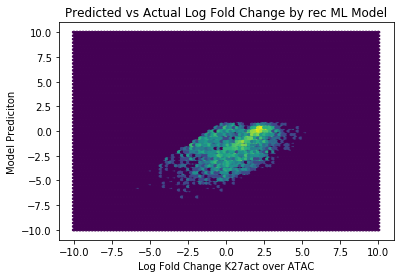

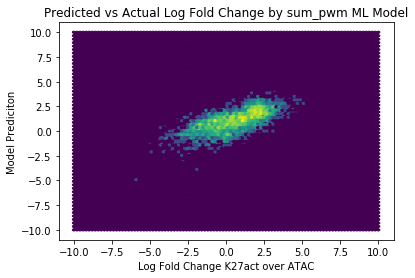

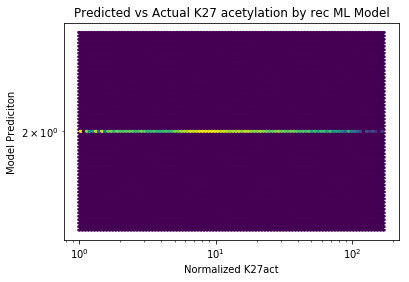

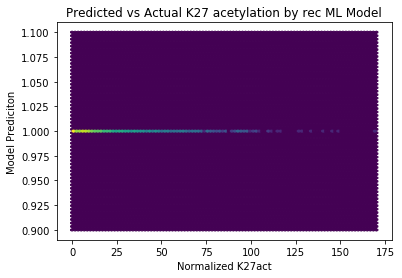

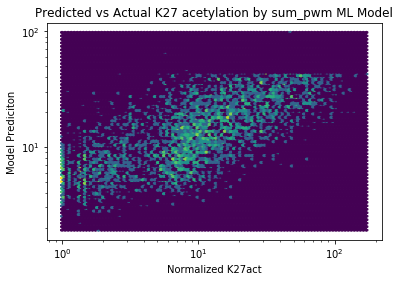

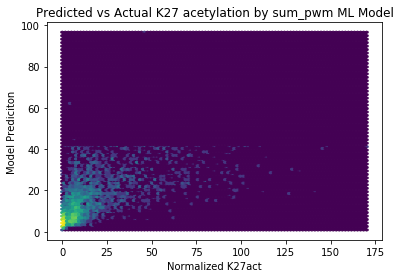

In [106]:
baseline_plots=False
# make some hexbin plots
if baseline_plots:
    for key in fbaseline_preds:
        plt.title('Predicted vs Actual Log Fold Change by {} Baseline Model'.format(key))
        plt.xlabel('Log Fold Change K27act over ATAC')
        plt.ylabel('Regression Prediciton')
        plt.hexbin(subpeaks['fold_change'], fbaseline_preds[key], bins='log', extent=(-10, 10, -10, 10))
        plt.show()


for key in ml_fold_preds:
    plt.title('Predicted vs Actual Log Fold Change by {} ML Model'.format(key))
    plt.xlabel('Log Fold Change K27act over ATAC')
    plt.ylabel('Model Prediciton')
    plt.hexbin(subpeaks['fold_change'], ml_fold_preds[key], bins='log', extent=(-10, 10, -10, 10))
    plt.show()
    
if baseline_plots:    
    for key in kbaseline_preds:
        plt.title('Predicted vs Actual K27 acetylation by {} Baseline Model'.format(key))
        plt.xlabel('Normalized K27act')
        plt.ylabel('Regression Prediciton')
        plt.hexbin(subpeaks['k27act'].clip(0)+1, kbaseline_preds[key].clip(0) +1, bins='log', xscale='log', yscale='log', extent=(0, 3, 0, 3))
        plt.show()
    
for key in ml_k27act_preds:
    plt.title('Predicted vs Actual K27 acetylation by {} ML Model'.format(key))
    plt.xlabel('Normalized K27act')
    plt.ylabel('Model Prediciton')
    plt.hexbin(subpeaks['k27act'].clip(0)+1, ml_k27act_preds[key].clip(0) +1, bins='log', xscale='log', yscale='log')
    plt.show()
    
    plt.title('Predicted vs Actual K27 acetylation by {} ML Model'.format(key))
    plt.xlabel('Normalized K27act')
    plt.ylabel('Model Prediciton')
    plt.hexbin(subpeaks['k27act'], ml_k27act_preds[key], bins='log')
    plt.show()

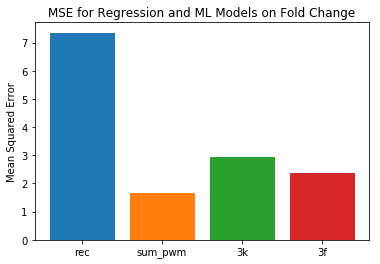

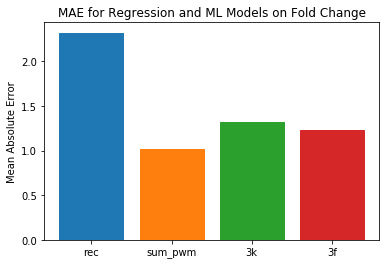

In [107]:
# mse plots
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
color_iter = iter(colors)

fmse=dict()
fmae=dict()
for key in fbaseline_preds:
    fmse[key] = np.mean((subpeaks['fold_change'] - fbaseline_preds[key]) **2)
    fmae[key] = np.mean(abs(subpeaks['fold_change'] - fbaseline_preds[key]))

for key in ml_fold_preds:
    fmse[key] = np.mean((subpeaks['fold_change'] - ml_fold_preds[key]) **2)
    fmae[key] = np.mean(abs(subpeaks['fold_change'] - ml_fold_preds[key]))
        
c = dict()
for key in fmse.keys():
    c[key] = next(color_iter)
    
barlist = plt.bar(range(len(fmse)), fmse.values())
for i in range(len(barlist)):
    barlist[i].set_color(colors[i])

plt.xticks(range(len(fmse)), fmse.keys())
plt.title('MSE for Regression and ML Models on Fold Change')
plt.ylabel('Mean Squared Error')
plt.show()

    
barlist = plt.bar(range(len(fmse)), fmae.values())
for i in range(len(barlist)):
    barlist[i].set_color(colors[i])

plt.xticks(range(len(fmae)), fmae.keys())
plt.title('MAE for Regression and ML Models on Fold Change')
plt.ylabel('Mean Absolute Error')
plt.show()

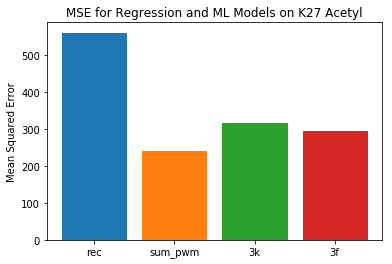

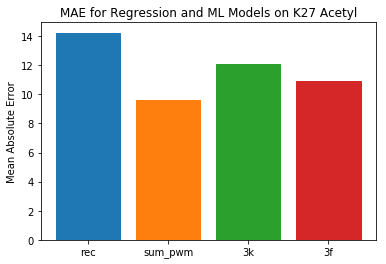

In [108]:
# mse plots
kmse=dict()
kmae=dict()
for key in kbaseline_preds:
    kmse[key] = np.mean((subpeaks['k27act'] - kbaseline_preds[key]) **2)
    kmae[key] = np.mean(abs(subpeaks['k27act'] - kbaseline_preds[key]))
    
for key in ml_k27act_preds:
    filter = [np.isfinite(m) for m in ml_k27act_preds[key]]
    kmse[key] = np.mean((subpeaks[(filter)]['k27act'] - ml_k27act_preds[key][(filter)]) **2)
    kmae[key] = np.mean(abs(subpeaks['k27act'] - ml_k27act_preds[key]))


barlist = plt.bar(range(len(kmse)), [kmse[k] for k in fmse.keys()])
for i in range(len(barlist)):
    barlist[i].set_color(colors[i])
plt.xticks(range(len(kmse)), fmse.keys())
plt.title('MSE for Regression and ML Models on K27 Acetyl')
plt.ylabel('Mean Squared Error')
plt.show()

barlist = plt.bar(range(len(fmse)), kmae.values())
for i in range(len(barlist)):
    barlist[i].set_color(colors[i])

plt.xticks(range(len(kmae)), kmae.keys())
plt.title('MAE for Regression and ML Models on K27 Acetyl')
plt.ylabel('Mean Absolute Error')
plt.show()

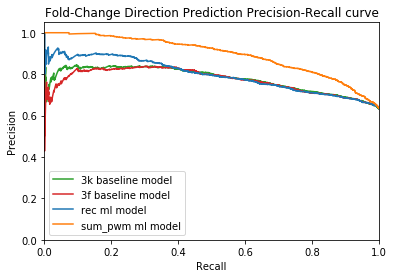

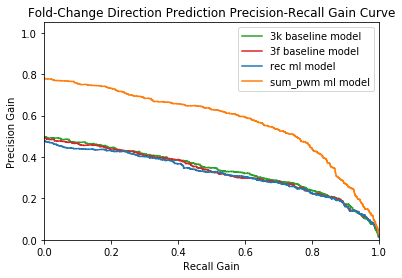

In [109]:
# pr curve
p_base=dict()
r_base=dict()
for key in fbaseline_preds:
    p_base[key], r_base[key], t = precision_recall_curve(subpeaks['fold_change']>0, fbaseline_preds[key])
    plt.plot(r_base[key], p_base[key], label='{} baseline model'.format(key), color=c[key])

p_ml=dict()
r_ml=dict()
for key in ml_fold_preds:
    filter = [np.isfinite(m) for m in ml_fold_preds[key]]
    p_ml[key], r_ml[key], t = precision_recall_curve(subpeaks[filter]['fold_change']>0, ml_fold_preds[key][filter])
    plt.plot(r_ml[key], p_ml[key], label='{} ml model'.format(key), color=c[key])

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend()
plt.title('Fold-Change Direction Prediction Precision-Recall curve')
plt.show()

# pr gain curve
prop_pos=sum(subpeaks['fold_change']>0)/len(subpeaks)
for key in fbaseline_preds:
    p_gain, r_gain = pr_gain.get_gain(p_base[key], r_base[key], prop_pos)
    plt.plot(r_gain, p_gain, label='{} baseline model'.format(key), color=c[key])

for key in ml_fold_preds:
    filter = [np.isfinite(m) for m in ml_fold_preds[key]]
    prop_pos=sum(subpeaks[filter]['fold_change']>0)/len(subpeaks[filter])
    p_gain, r_gain = pr_gain.get_gain(p_ml[key], r_ml[key], prop_pos)
    plt.plot(r_gain, p_gain, label='{} ml model'.format(key), color=c[key])

plt.xlabel('Recall Gain')
plt.ylabel('Precision Gain')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend()
plt.title('Fold-Change Direction Prediction Precision-Recall Gain Curve')
plt.show()

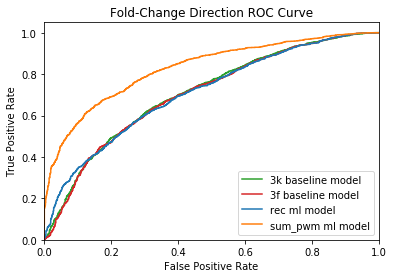

In [110]:
# roc curve
fpr_base=dict()
tpr_base=dict()
for key in fbaseline_preds:
    fpr_base[key], tpr_base[key], t = roc_curve(subpeaks['fold_change']>0, fbaseline_preds[key])
    plt.plot(fpr_base[key], tpr_base[key], label='{} baseline model'.format(key), color=c[key])

fpr_ml=dict()
tpr_ml=dict()
for key in ml_fold_preds:
    filter = [np.isfinite(m) for m in ml_fold_preds[key]]
    fpr_ml[key], tpr_ml[key], t = roc_curve(subpeaks[filter]['fold_change']>0, ml_fold_preds[key][filter])
    plt.plot(fpr_ml[key], tpr_ml[key], label='{} ml model'.format(key), color=c[key])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend()
plt.title('Fold-Change Direction ROC Curve')
plt.show()

In [111]:
# compare two ml models -- are they picking up on the same things?
key_1 = 'fconv'
key_2 = 'fpwm'

plt.title('Predicted Log Fold Change by {} and {} ML Model'.format(key_1, key_2))
plt.xlabel('{} Prediction for Log Fold Change'.format(key_1))
plt.ylabel('{} Prediction for Log Fold Change'.format(key_2))
plt.hexbin(ml_fold_preds[key_1], ml_fold_preds[key_2], bins='log', extent=(-10, 10, -10, 10))
plt.show()

plt.title('Predicted K27 Acetylation by {} and {} ML Models'.format(key_1, key_2))
plt.xlabel('{} Prediction for K27act'.format(key_1))
plt.ylabel('{} Prediction for K27act'.format(key_2))
plt.hexbin(ml_k27act_preds[key_1].clip(0) +1, ml_k27act_preds[key_2].clip(0) +1, bins='log', xscale='log', yscale='log')
plt.show()

KeyError: 'fconv'

In [ ]:
# compare two baseline models -- are they picking up on the same things?
key_1 = '3f'
key_2 = '3k'

plt.title('Predicted Log Fold Change by {} and {} ML Model'.format(key_1, key_2))
plt.xlabel('{} Prediction for Log Fold Change'.format(key_1))
plt.ylabel('{} Prediction for Log Fold Change'.format(key_2))
plt.hexbin(fbaseline_preds[key_1], fbaseline_preds[key_2], bins='log', extent=(-10, 10, -10, 10))
plt.show()

plt.title('Predicted K27 Acetylation by {} and {} ML Models'.format(key_1, key_2))
plt.xlabel('{} Prediction for K27act'.format(key_1))
plt.ylabel('{} Prediction for K27act'.format(key_2))
plt.hexbin(kbaseline_preds[key_1].clip(0) +1, kbaseline_preds[key_2].clip(0) +1, bins='log', xscale='log', yscale='log', extent=(0, 3, 0, 3))
plt.show()

In [ ]:
# get model dreams?? will this even work? 

In [ ]:
ml_k27act_preds.keys()

In [ ]:
np.e ** np.log(47)